In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

import pickle
import os
import sys
import glob
from collections import OrderedDict
from tqdm import tqdm

In [2]:
sys.path.append('../../')
import compute_preprocessing

In [3]:
def convert_input_for_ann_10D(
        times,
        q,
        chi1, theta1, phi1,
        chi2, theta2, phi2,
        inclination, phiRef
        ):
    X = []
    for _q, _chi1, _theta1, _phi1, _chi2, _theta2, _phi2, _inclination, _phiRef in zip(q, chi1, theta1, phi1, chi2, theta2, phi2, inclination, phiRef):
        for t in times:
            X.append([t, _q, _chi1, _theta1, _phi1, _chi2, _theta2, _phi2, _inclination, _phiRef])
    X = np.asarray(X)
    return X

In [4]:
def compute_model_input_10D(times, q, chi1, theta1, phi1, chi2, theta2, phi2, inclination, phiRef):
    
    # broadcast and stack with times array
    output = np.ones(shape=(times.shape[0], 1))
    output = output * np.array([q, chi1, theta1, phi1, chi2, theta2, phi2, inclination, phiRef])
    
    output = np.column_stack((times, output))
    
    return output

In [5]:
def convert_input_for_ann(times, q, chi1, theta1):
    X = []
    for _q, _chi1, _theta1 in zip(q, chi1, theta1):
        for t in times:
            X.append([t, _q, _chi1, _theta1])
    X = np.asarray(X)
    return X

In [6]:
def compute_model_input(times, q, chi1, theta1):
    
    # broadcast and stack with times array
    output = np.ones(shape=(times.shape[0], 1))
    output = output * np.array([q, chi1, theta1])
    
    output = np.column_stack((times, output))
    
    return output

In [7]:
import tensorflow as tf

In [8]:
import pugna.layers
import pugna.activations

In [9]:
# https://datascience.stackexchange.com/questions/58884/how-to-create-custom-activation-functions-in-keras-tensorflow
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})

In [10]:
def preload_amp(data_dir):

    pkl_filename = os.path.join(data_dir, "pre_processing_1e5/times_scaler.pkl")
    with open(pkl_filename, 'rb') as file:
        times_scaler = pickle.load(file)
    
    
    times = np.load(os.path.join(data_dir, "training_data_1e5/times.npy"))
    
    times_scaled = times_scaler.transform(times[:, np.newaxis])[:, 0]
    
    ys_raw = np.load(os.path.join(data_dir, "training_data_1e5/amplitude.npy"))
    ys_processing_params = np.load(os.path.join(data_dir, "pre_processing_1e5/amp_preprocessing_params.npz"))
    
    ys = compute_preprocessing.apply_pre_process_forward(ys_raw, ys_processing_params['mean'], ys_processing_params['max'])
    
    coords = np.load(os.path.join(data_dir, "training_data_1e5/coords.npy"))
#     X = convert_input_for_ann(times_scaled, coords[0], coords[1], coords[2])

    

                     
    return times, times_scaled, coords, ys_raw, ys, ys_processing_params

In [11]:
mfiles = sorted(glob.glob("00*/model*"))
print(mfiles)

models = OrderedDict()
for mfile in mfiles:
    key = mfile.split('/')[0]
    models[key] = tf.keras.models.load_model(mfile,
                                       custom_objects={'Mscale': pugna.layers.Mscale,
                                                       'Activation':tf.keras.layers.Activation,
                                                       'name':pugna.activations.s2relu})

['001/model.h5']


In [12]:
models.keys()

odict_keys(['001'])

In [13]:
data_dir="/home/sebastian.khan/git/stk/ml/waveforms/april2021/3d-precession/10d_test/"

In [14]:
times, times_scaled, coords, ys_raw, ys, ys_processing_params = preload_amp(data_dir=data_dir)

In [15]:
coords.shape

(9, 100000)

In [16]:
ys.shape

(100000, 1099)

In [17]:
times

array([-499.50433946, -499.00433946, -498.50433946, ...,   48.49566054,
         48.99566054,   49.49566054])

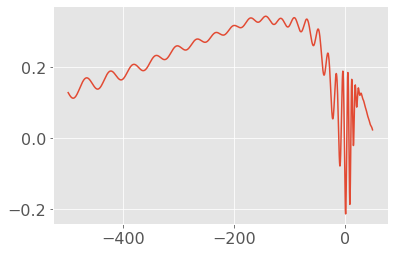

In [18]:
plt.figure()
plt.plot(times, ys[0])

In [19]:
def compare_models(index, ys_raw, preprocessing_params, coords, times_scaled, times, models, ylim=None, xlim=None):
    q = np.around(coords[0,index], 3)
    chi1 = np.around(coords[1,index], 3)
    theta1 = np.around(coords[2,index], 3)
    phi1 = np.around(coords[3,index], 3)
    chi2 = np.around(coords[4,index], 3)
    theta2 = np.around(coords[5,index], 3)
    phi2 = np.around(coords[6,index], 3)
    inclination = np.around(coords[7,index], 3)
    phiRef = np.around(coords[8,index], 3)
    
    title = f"""q = {q}, chi1 = {chi1}, theta1 = {theta1}, phi1 = {phi1},
chi2 = {chi2}, theta2 = {theta2}, phi2 = {phi2},
inclination = {inclination}, phiRef = {phiRef}"""
    
    Xhat = compute_model_input_10D(times_scaled, q, chi1, theta1, phi1, chi2, theta2, phi2, inclination, phiRef)
    yhats = OrderedDict()
    for k, v in models.items():
        yhat = models[k].predict(Xhat).T
        
        yhats[k] = compute_preprocessing.apply_pre_process_reverse(yhat, preprocessing_params['mean'], preprocessing_params['max'])[0]
#         yhats[k] = yhat[0]
        
        
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 1, 1)
    plt.plot(times, ys_raw[index], label='data')
    for k, v in yhats.items():
        plt.plot(times, v, label=k, ls='--')
    if xlim:
        plt.xlim(*xlim)
#     plt.xlim(-200, 50)
#     plt.xlim(-10, 50)
    plt.yscale('log')
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.subplot(2, 1, 2)
    for k, v in yhats.items():
        plt.plot(times, 100*np.abs((v-ys_raw[index])/ys_raw[index]), label=f"% (data-{k})")
    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)
#     plt.xlim(-200, 50)
#     plt.xlim(-10, 50)
#     plt.ylim(-10, 10)
#     plt.yscale('log')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [20]:
np.where((coords[1] > 0.98) & (coords[2] > 1.3))

(array([  118,   181,   290,   302,   303,   422,   486,   514,   616,
          705,   917,   994,  1444,  1500,  1766,  1993,  2158,  2360,
         2389,  2586,  2841,  2995,  3137,  3488,  3522,  3568,  3583,
         3703,  3975,  4044,  4220,  4243,  4271,  4344,  4359,  4428,
         4820,  5064,  5351,  5471,  5483,  5623,  5671,  5741,  5896,
         6320,  6329,  6355,  6583,  6737,  6816,  6864,  6932,  7078,
         7122,  7203,  7898,  8776,  8976,  9042,  9250,  9274,  9290,
         9385,  9420,  9544,  9609, 10251, 10340, 10475, 10604, 10642,
        10643, 10667, 10784, 10857, 10932, 10986, 11121, 11180, 11418,
        11918, 12062, 12198, 12239, 12315, 12401, 12600, 12636, 12675,
        13012, 13078, 13220, 13537, 13605, 13665, 13773, 13865, 13873,
        13909, 13912, 14231, 14419, 14896, 14953, 15029, 15442, 15740,
        15936, 16145, 16386, 16406, 16610, 17034, 17094, 17188, 17280,
        17329, 17504, 17533, 17763, 17809, 17961, 18025, 18098, 18243,
      

In [21]:
np.where((coords[1] > 0.6) & (coords[2] > 1.3) & (coords[2] < 1.6))

(array([    1,    14,    27, ..., 99949, 99981, 99999]),)

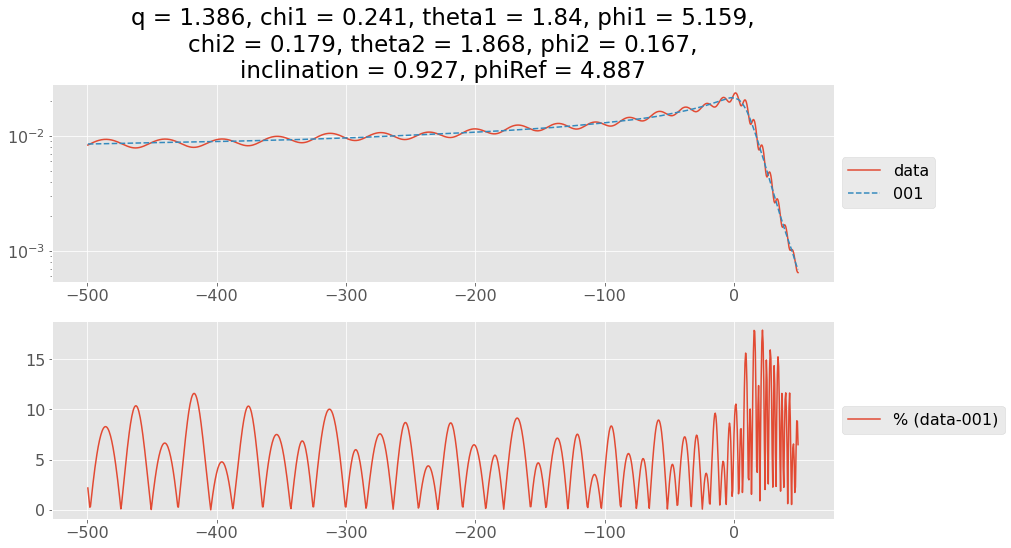

In [22]:
# compare_models(index=789, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models, xlim=(-10,50))
compare_models(index=789, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)
# compare_models(index=789, ys_raw=ys, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)

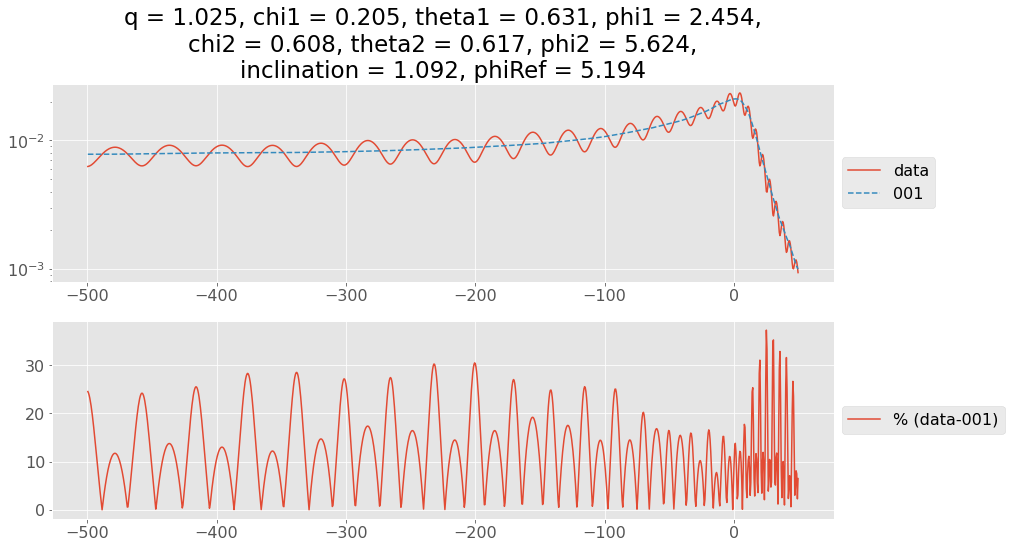

In [23]:
# compare_models(index=10, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models, xlim=(-10,50))
compare_models(index=10, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)
# compare_models(index=10, ys_raw=ys, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)

In [24]:
# compare_models(index=361, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models, xlim=(-10,50))
# compare_models(index=361, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models={'005':models['005']}, xlim=(-10,50))

In [25]:
# compare_models(index=361, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models, xlim=(-10,50))
# compare_models(index=361, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models={'009':models['009']}, xlim=(-10,50))

In [26]:
# compare_models(index=361, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models, xlim=(-10,50))
# compare_models(index=361, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models={'002':models['002']}, xlim=(-10,50))

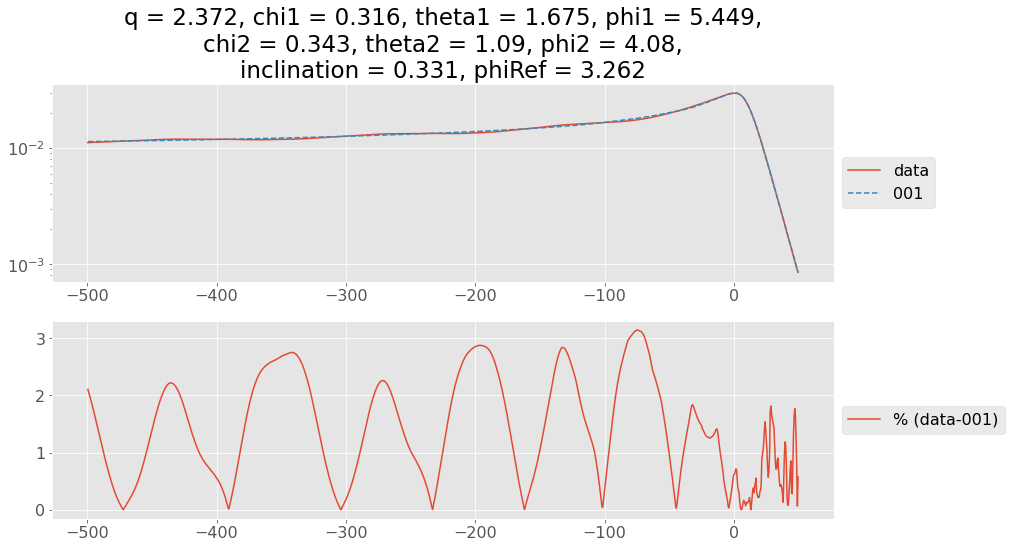

In [27]:
# compare_models(index=82, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models, xlim=(-10,50))
compare_models(index=82, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)

In [28]:
# Xhat = convert_input_for_ann(times_scaled, *coords[:, :10])
# # Xhat = convert_input_for_ann(times_scaled, *coords)
# yhat = models['008'].predict(Xhat).T

In [29]:
# yhat.shape

In [30]:
def compute_errors(ys_raw, preprocessing_params, coords, times_scaled, times, models):
    
    n_cases = coords.shape[1]
    max_loop = 100
#     max_loop = n_cases
    
    yhats = OrderedDict()
    errors = OrderedDict()
    for k, v in models.items():
        
        if os.path.exists(f"errors_{k}.npy"):
            print("ALREADY CALCULATED LOADING DATA")
            errors[k] = np.load(f"errors_{k}.npy")
            continue
        
        print(f"working model: {k}")
        yhats[k] = np.zeros(shape=(n_cases, times_scaled.shape[0]))
        errors[k] = np.zeros(shape=(max_loop))

#         for index in tqdm(range(n_cases)):
        for index in tqdm(range(max_loop)):

            q = coords[0,index]
            chi1 = coords[1,index]
            theta1 = coords[2,index]
            phi1 = coords[3,index]
            chi2 = coords[4,index]
            theta2 = coords[5,index]
            phi2 = coords[6,index]
            inclination = coords[7,index]
            phiRef = coords[8,index]

            Xhat = compute_model_input_10D(times_scaled, q, chi1, theta1, phi1, chi2, theta2, phi2, inclination, phiRef)
        
            yhat = models[k].predict(Xhat).T
            tt = compute_preprocessing.apply_pre_process_reverse(yhat, preprocessing_params['mean'], preprocessing_params['max'])[0]
            yhats[k][index] = tt
            
            errors[k][index] = np.max(100*np.abs(ys_raw[index]-yhats[k][index])/ys_raw[index])
            
        print("SAVING")
        np.save(f"errors_{k}.npy", errors[k])
        
    return errors

In [31]:
%%time
errors = compute_errors(ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)

  0%|          | 0/100 [00:00<?, ?it/s]

working model: 001


100%|██████████| 100/100 [00:19<00:00,  5.00it/s]


SAVING
CPU times: user 24.1 s, sys: 1.77 s, total: 25.8 s
Wall time: 20 s


In [32]:
errors['001'].shape

(100,)

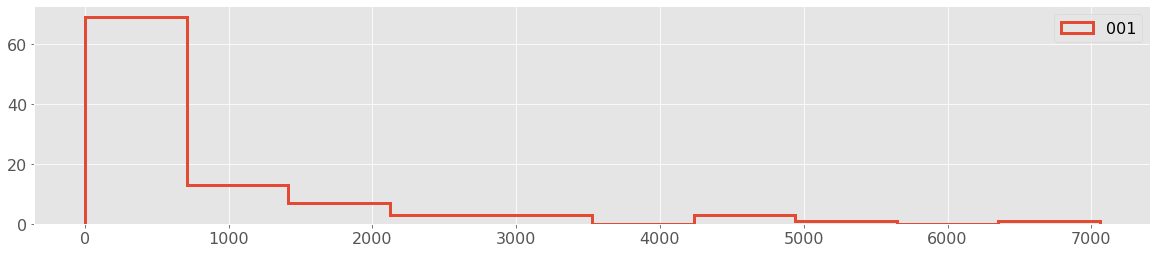

In [33]:
plt.figure(figsize=(20, 4))
for i,(k,v) in enumerate(errors.items()):
    plt.subplot(1, len(errors.keys()), i+1)
    plt.hist(np.abs(v), label=k, histtype='step', linewidth=3);
#     , density=True
    plt.legend()
# plt.xlim(0, 100)

In [34]:
for i,(k,v) in enumerate(errors.items()):
    median_value = np.median(np.abs(v))
    print(f"{k}: {median_value}")

001: 67.1408065576856


In [35]:
max_idx = {}
for i,(k,v) in enumerate(errors.items()):
    max_value = np.max(np.abs(v))
    print(f"{k}: {max_value}")
    max_idx[k] = np.where(np.abs(v) == max_value)

001: 7058.559857923902


In [36]:
max_idx

{'001': (array([5]),)}

Text(0, 0.5, '$\\theta_1$')

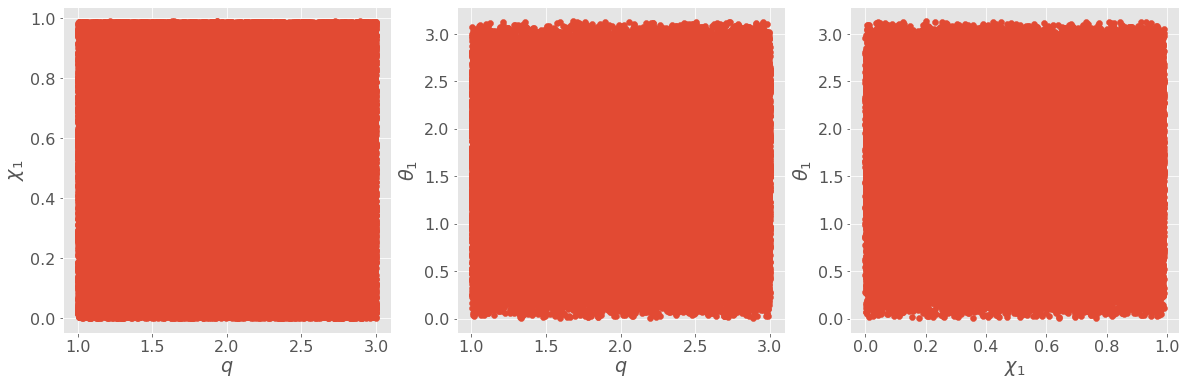

In [37]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.scatter(coords[0], coords[1])
plt.xlabel(r'$q$')
plt.ylabel(r'$\chi_1$')
plt.subplot(1, 3, 2)
plt.scatter(coords[0], coords[2])
plt.xlabel(r'$q$')
plt.ylabel(r'$\theta_1$')
plt.subplot(1, 3, 3)
plt.scatter(coords[1], coords[2])
plt.xlabel(r'$\chi_1$')
plt.ylabel(r'$\theta_1$')

In [38]:
from results import create_multidim_plot

In [39]:
coords.shape

(9, 100000)

In [40]:
errors['001'].shape[0]

100

In [41]:

mean = (1, 2)
cov = [[1, 0], [0, 100]]
x, y = np.random.multivariate_normal(mean, cov, (1000, 1000)).T

parameters = ['q', 'chi1', 'theta1', 'phi1', 'chi2', 'theta2', 'phi2','inclination', 'phiRef']


samples = np.recarray(len(x), dtype=[(p, float) for p in parameters])
for i in range(coords.shape[0]):
    samples[parameters[i]] = coords[i]

zvals = np.abs(errors['001'])

# pars_to_show = ['q', 'chi1', 'theta1']
# labels = {'q':'q', 'chi1':r'$\chi_1$', 'theta1':r'$\theta_1$'}

pars_to_show = ['q', 'chi1', 'theta1', 'phi1', 'chi2', 'theta2', 'phi2','inclination', 'phiRef']
labels = {
    'q':'q',
    'chi1':r'$\chi_1$',
    'theta1':r'$\theta_1$',
    'phi1':r'$\phi_1$',
    'chi2':r'$\chi_2$',
    'theta2':r'$\theta_2$',
    'phi2':r'$\phi_2$',
    'inclination':r'$\iota$',
    'phiRef':r'$\phi_{\rm{ref}}$',
}

# mins = {'x0':-4, 'x1':-4, 'y0':-4}
# maxs = {'x0':4, 'x1':4, 'y0':4}

fig, axes_dict = create_multidim_plot(
    pars_to_show,
    samples,
    zvals=zvals,
    show_colorbar=True,
    labels=labels,
    cbar_label='Zvals',
    cb_scale=14,
    scatter_cmap='viridis_r',
    scatter_size=20
)
fig.suptitle('errors')

ValueError: could not broadcast input array from shape (100000,) into shape (1000,)

Text(0, 0.5, '$\\theta_1$')

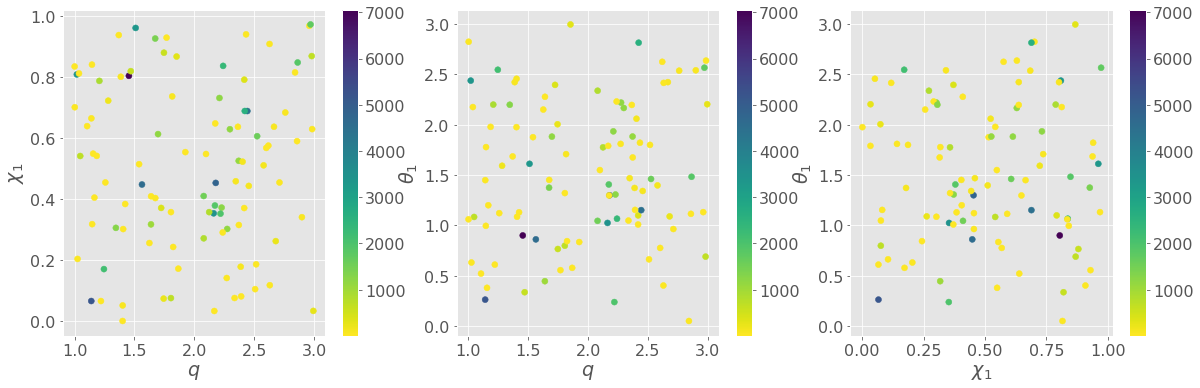

In [42]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.scatter(coords[0][:100], coords[1][:100], c=np.abs(errors['001']), cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\chi_1$')
plt.subplot(1, 3, 2)
plt.scatter(coords[0][:100], coords[2][:100], c=np.abs(errors['001']), cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\theta_1$')
plt.subplot(1, 3, 3)
plt.scatter(coords[1][:100], coords[2][:100], c=np.abs(errors['001']), cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$\chi_1$')
plt.ylabel(r'$\theta_1$')

In [43]:
worst_cases_values = np.flip(np.sort(np.abs(errors['001'])))[:10]
worst_cases_idx = np.array([np.where(np.abs(errors['001']) == w_c)[0][0] for w_c in worst_cases_values])

# worst_cases_values = np.flip(np.sort(np.abs(errors['001'])))[-10:]
# worst_cases_idx = np.array([np.where(np.abs(errors['001']) == w_c)[0][0] for w_c in worst_cases_values])

# worst_cases_values = np.flip(np.sort(np.abs(errors['002'])))[:10]
# worst_cases_idx = np.array([np.where(np.abs(errors['002']) == w_c)[0][0] for w_c in worst_cases_values])

# worst_cases_values = np.flip(np.sort(np.abs(errors['009'])))[:10]
# worst_cases_idx = np.array([np.where(np.abs(errors['009']) == w_c)[0][0] for w_c in worst_cases_values])

In [44]:
worst_cases_values

array([7058.55985792, 5168.31014387, 4815.46192774, 4581.54771394,
       4488.27929387, 3463.3106407 , 3381.73281388, 3323.23376411,
       2592.89658265, 2344.9071452 ])

In [45]:
worst_cases_idx

array([ 5, 70,  3,  9, 75, 13, 19,  8, 88, 11])

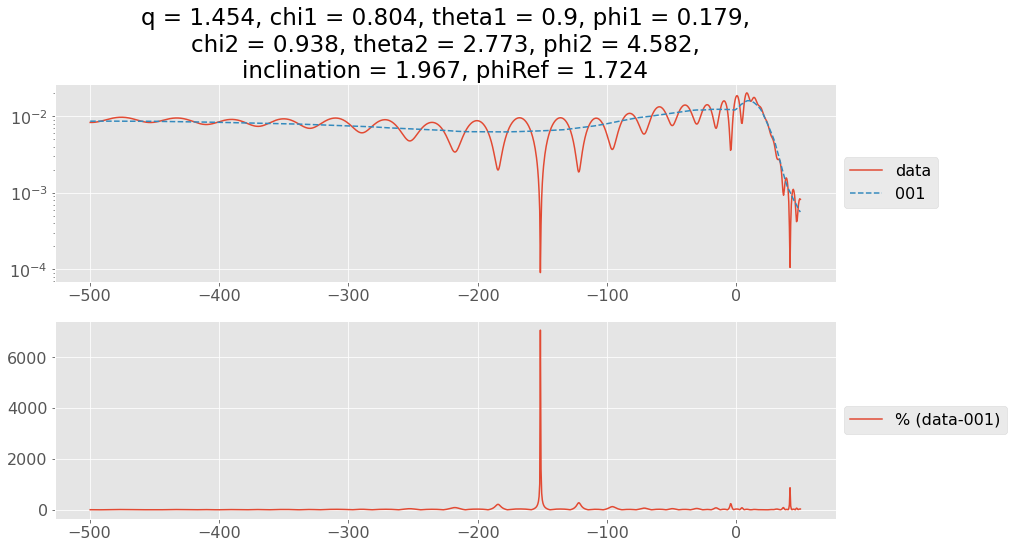

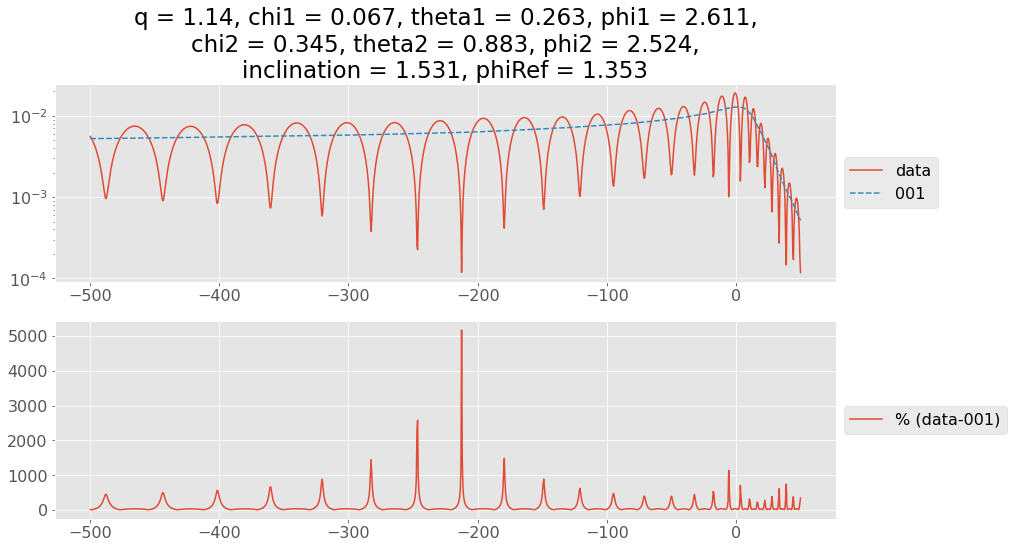

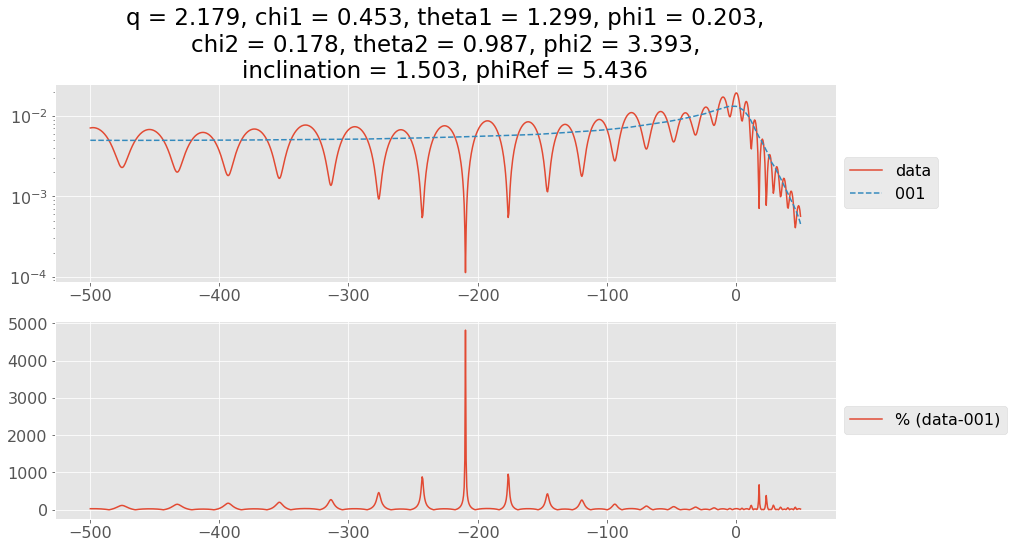

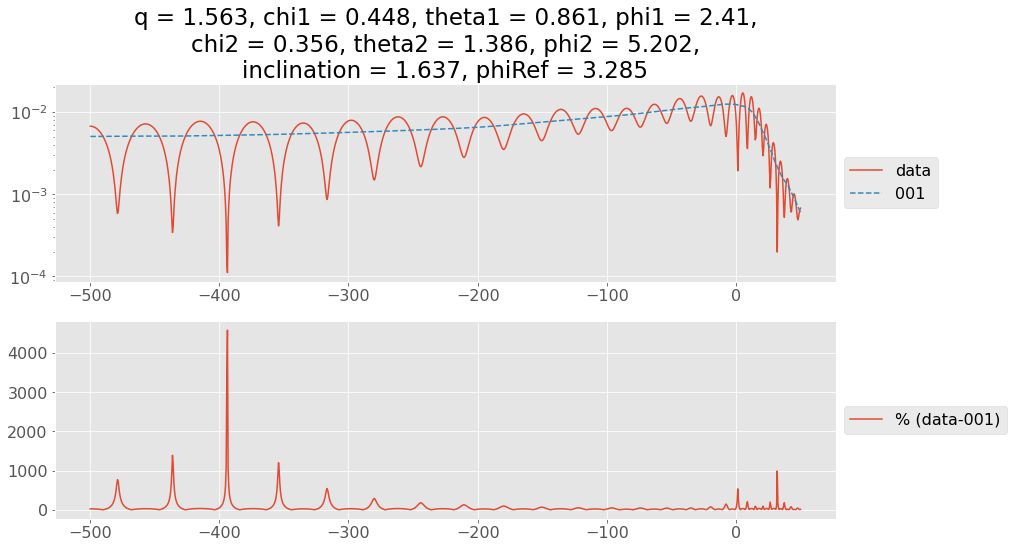

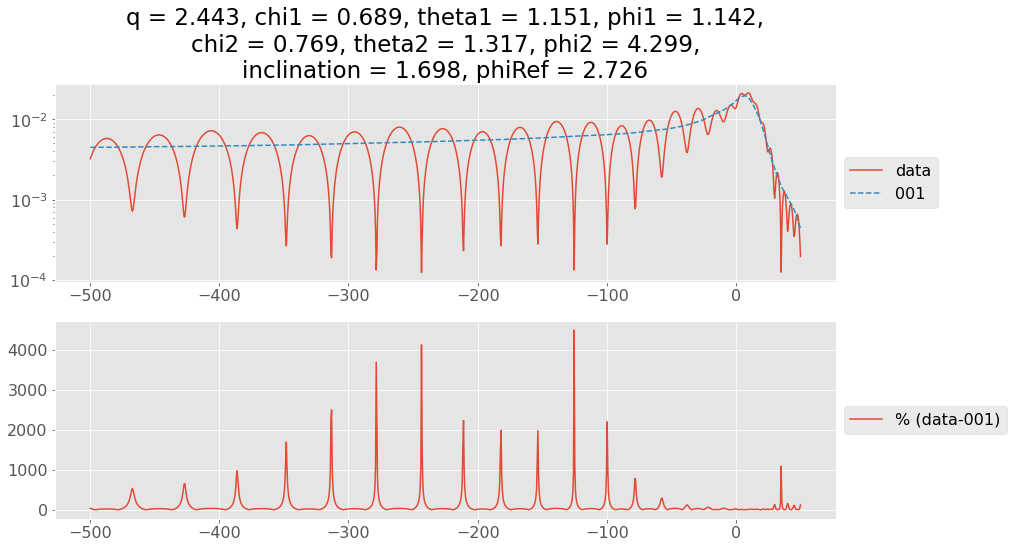

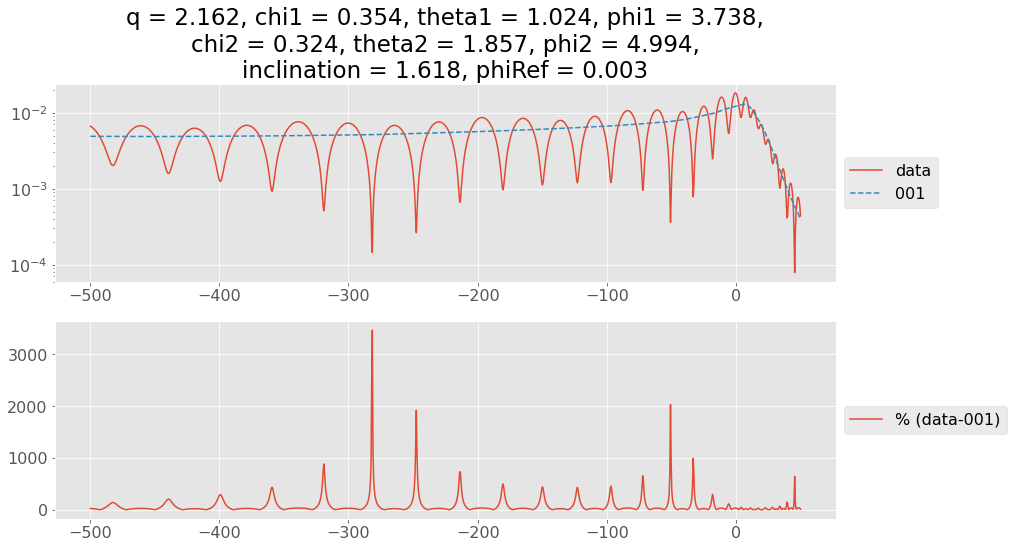

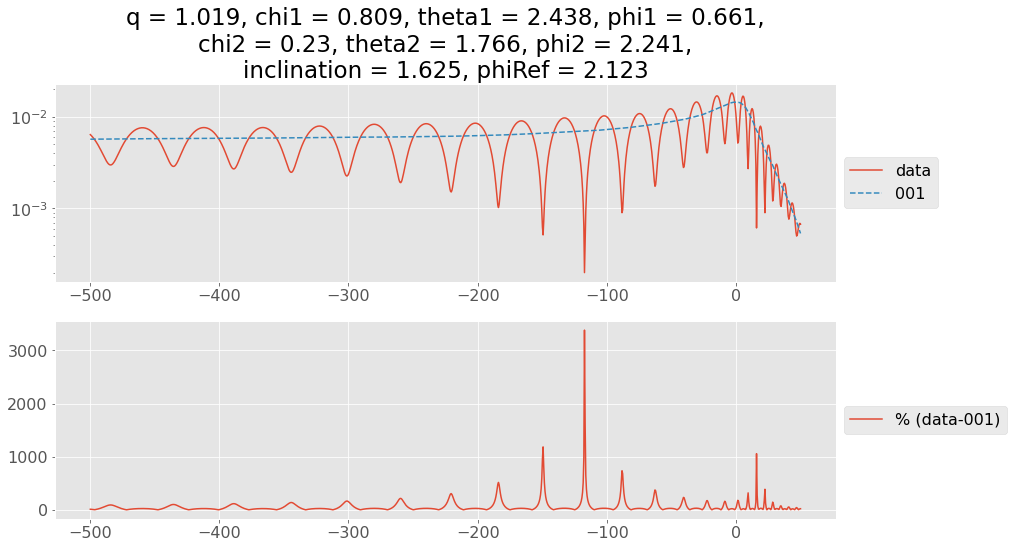

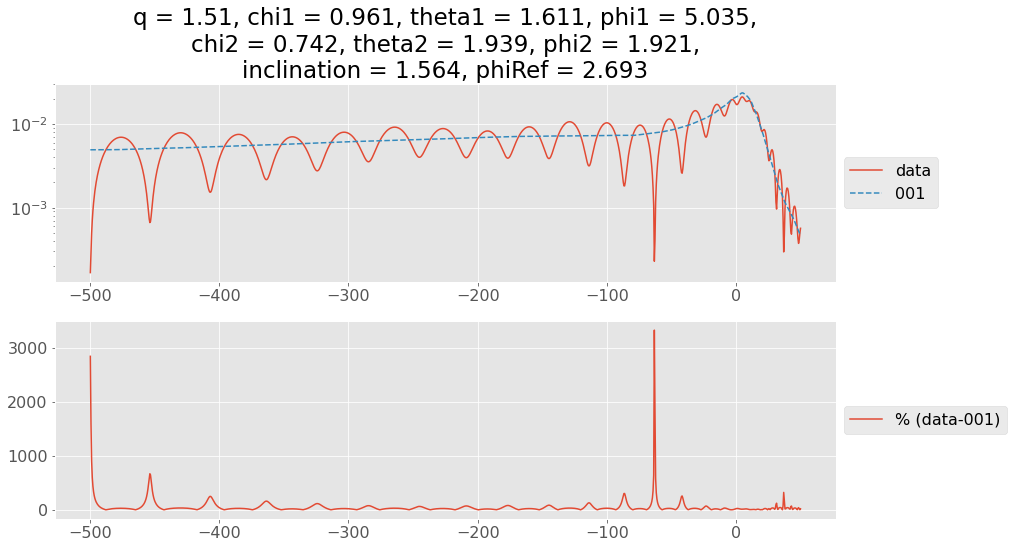

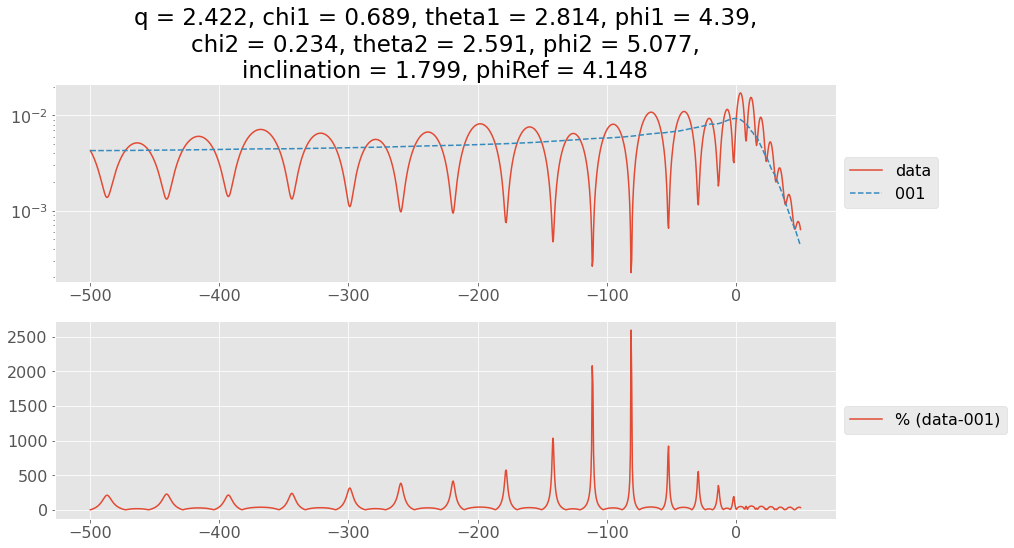

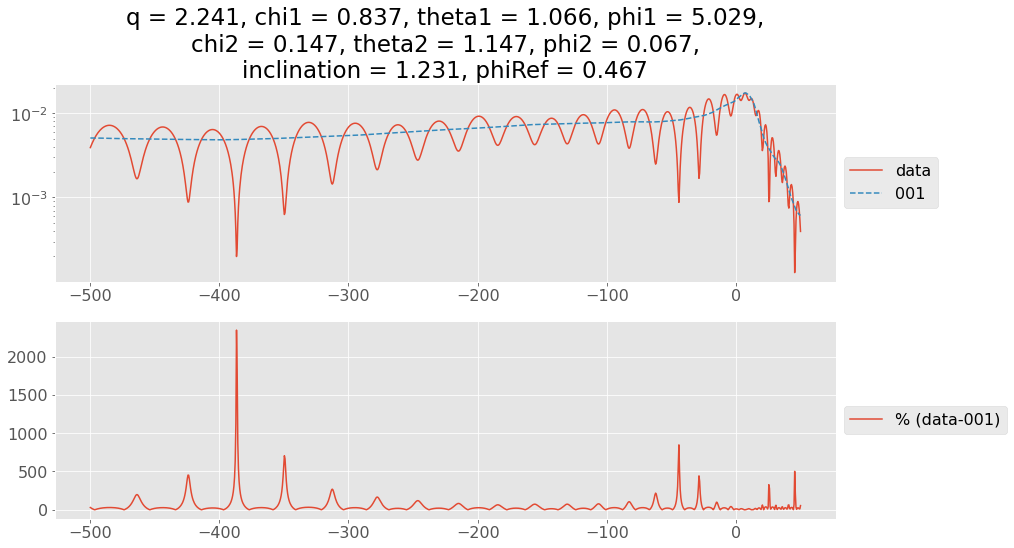

In [46]:
for index in worst_cases_idx:
    compare_models(index=index, ys_raw=ys_raw, preprocessing_params=ys_processing_params,
                   coords=coords, times_scaled=times_scaled, times=times, models={'001':models['001']})#, xlim=(-200,50), ylim=(-10, 10))

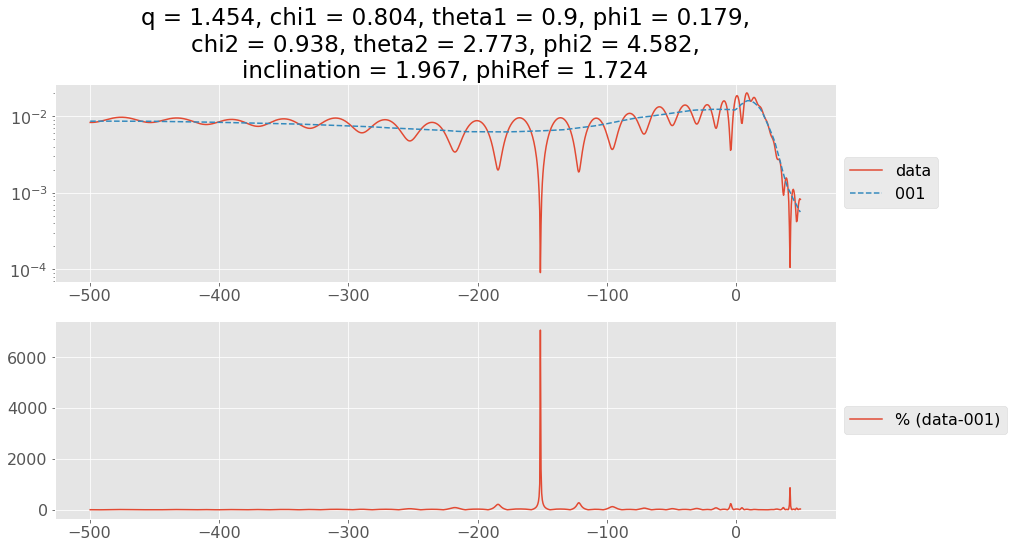

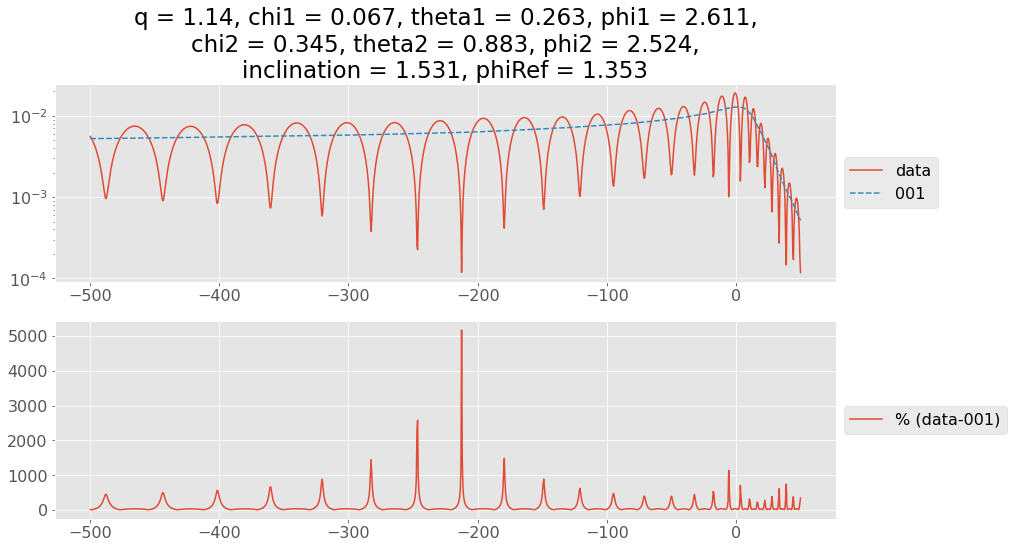

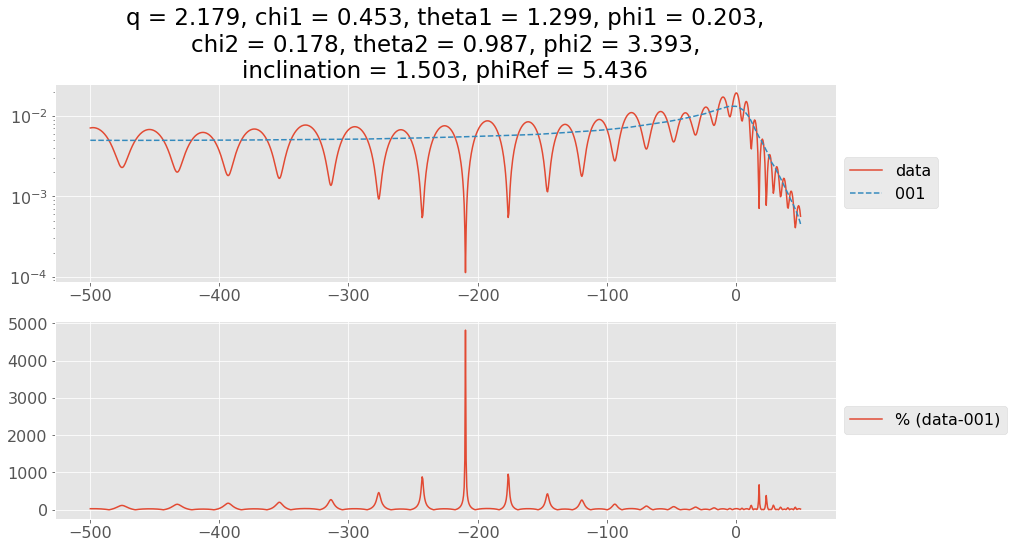

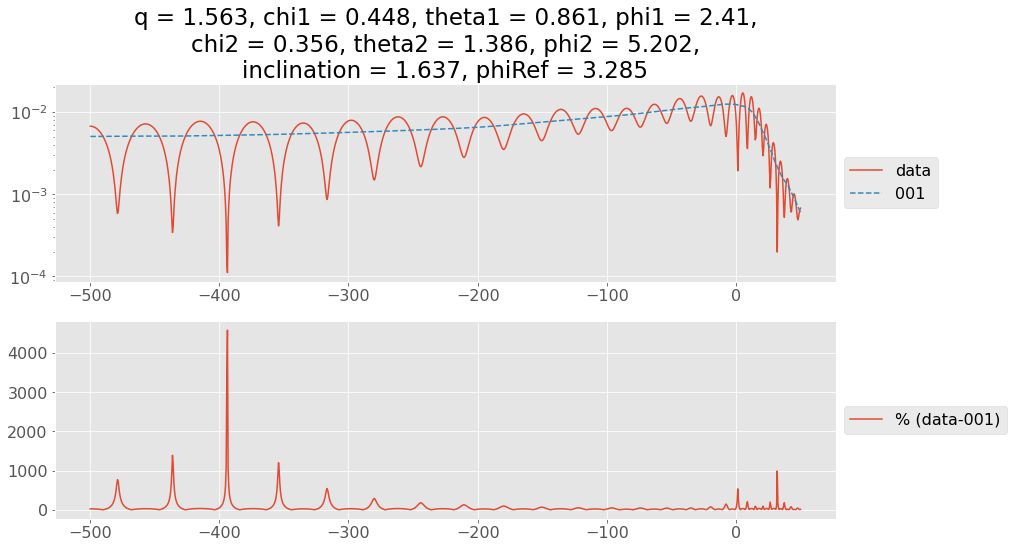

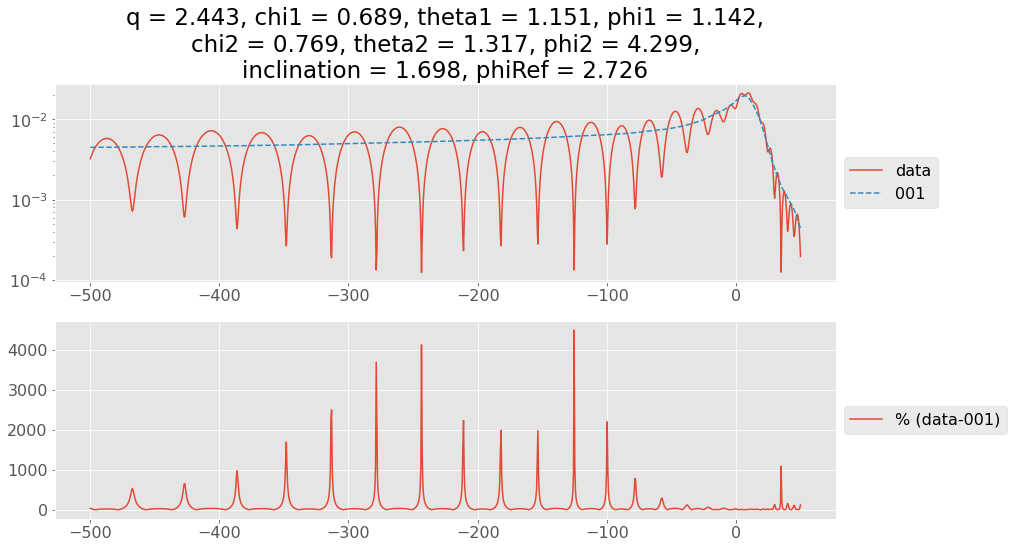

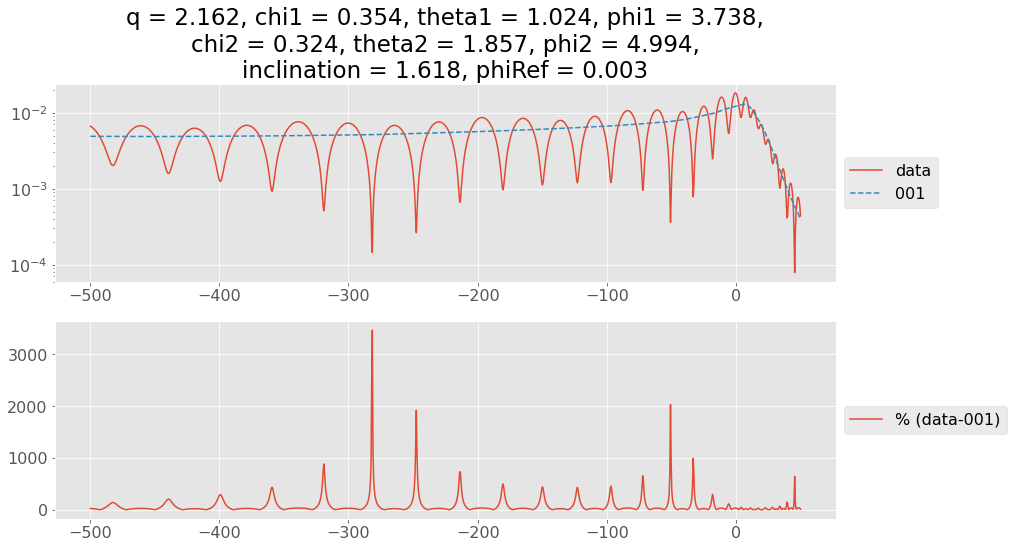

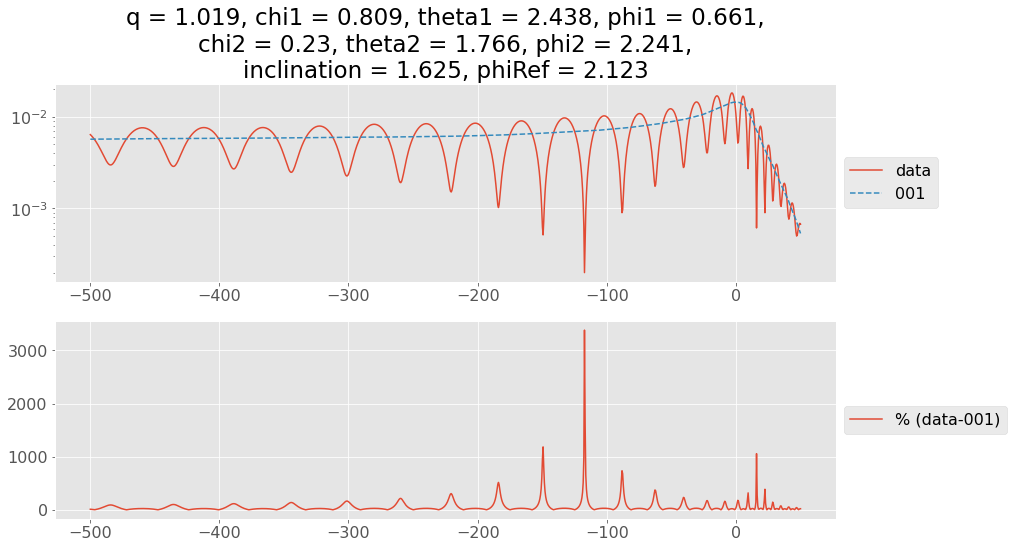

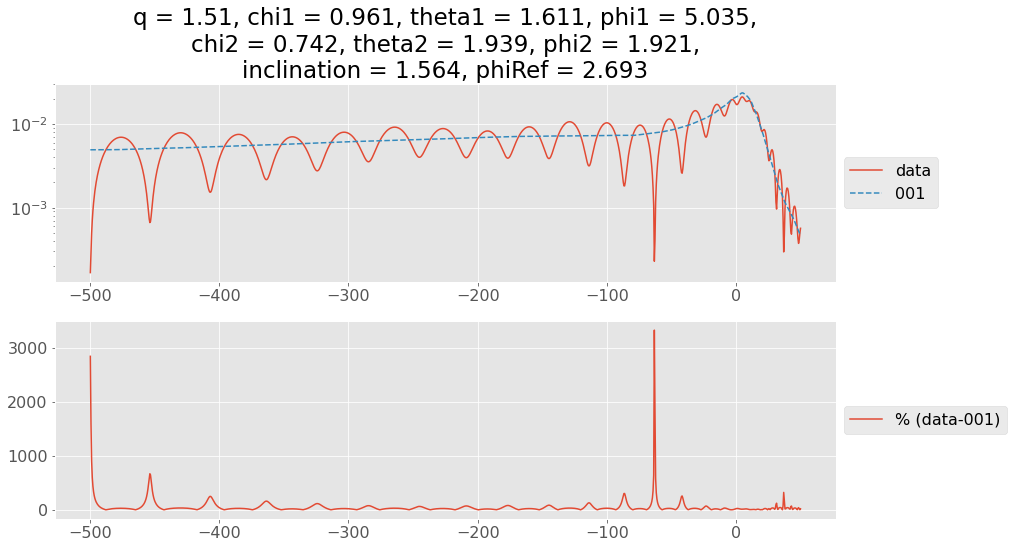

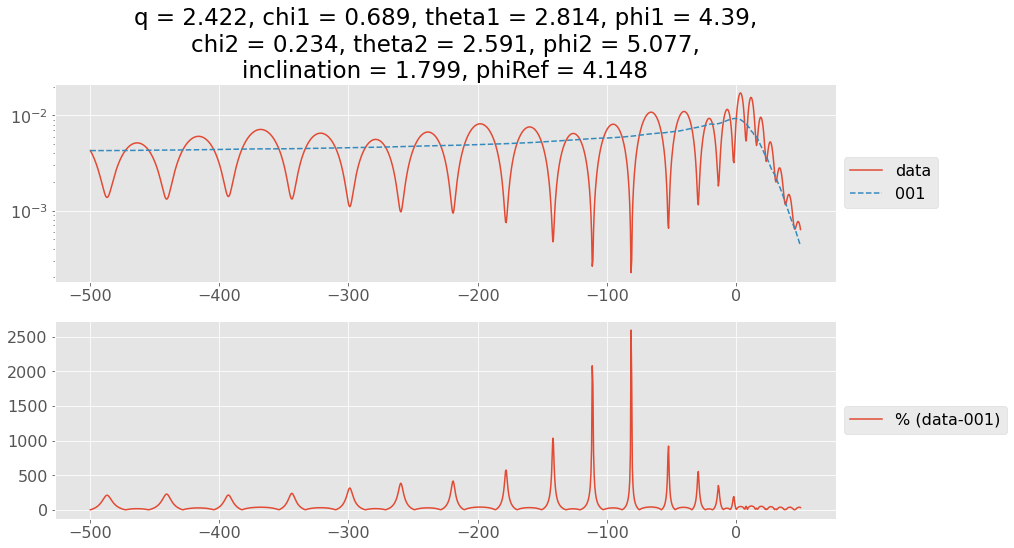

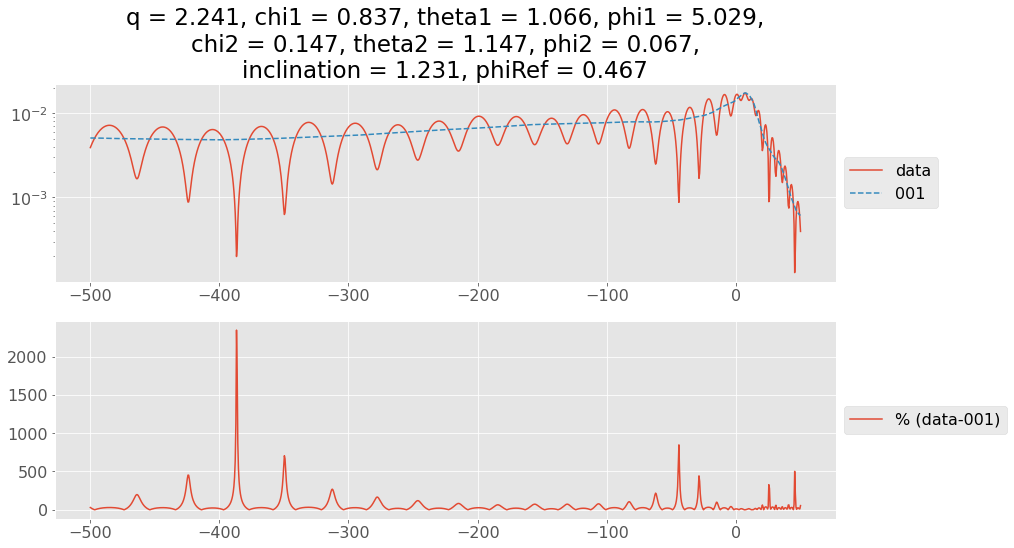

In [47]:
for index in worst_cases_idx:
    compare_models(index=index, ys_raw=ys_raw, preprocessing_params=ys_processing_params,
                   coords=coords, times_scaled=times_scaled, times=times, models=models)#, xlim=(-200,50), ylim=(-10, 10))